## Imports

In [5]:
import pandas as pd
import numpy as np
import datetime
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


## Récupération des data

In [6]:
btcusd_data = pd.read_csv('./data/btcusd_1-min_data.csv')

print(f"Dataset BTC/USD original shape: {btcusd_data.shape}")
print(f"Colonnes: {btcusd_data.columns.tolist()}")

# convertir le Timestamp Unix en datetime
btcusd_data['Timestamp'] = pd.to_datetime(btcusd_data['Timestamp'], unit='s')

# trier par timestamp
btcusd_data = btcusd_data.sort_values('Timestamp').reset_index(drop=True)

# 1 donnée par heure
btcusd_data.set_index('Timestamp', inplace=True)
btcusd_daily = btcusd_data['Close'].resample('H').last()
btcusd_daily = btcusd_daily.dropna().reset_index()
btcusd_daily.columns = ['Date', 'Close']

print(f"\nDataset BTC/USD réduit à 1 par heure : {btcusd_daily.shape}")
print(f"\nPremières lignes:")
print(btcusd_daily.head())
print(f"\nDernières lignes:")
print(btcusd_daily.tail())

# utiliser la colonne close
data = btcusd_daily['Close'].values.reshape(-1, 1)
print(f"\nDonnées préparées pour le modèle: shape = {data.shape}")

Dataset BTC/USD original shape: (7258717, 6)
Colonnes: ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']

Dataset BTC/USD réduit à 1 par heure : (120980, 2)

Premières lignes:
                 Date  Close
0 2012-01-01 10:00:00   4.58
1 2012-01-01 11:00:00   4.58
2 2012-01-01 12:00:00   4.58
3 2012-01-01 13:00:00   4.58
4 2012-01-01 14:00:00   4.58

Dernières lignes:
                      Date     Close
120975 2025-10-20 19:00:00  110840.0
120976 2025-10-20 20:00:00  111133.0
120977 2025-10-20 21:00:00  110595.0
120978 2025-10-20 22:00:00  110860.0
120979 2025-10-20 23:00:00  110595.0

Données préparées pour le modèle: shape = (120980, 1)

Dataset BTC/USD réduit à 1 par heure : (120980, 2)

Premières lignes:
                 Date  Close
0 2012-01-01 10:00:00   4.58
1 2012-01-01 11:00:00   4.58
2 2012-01-01 12:00:00   4.58
3 2012-01-01 13:00:00   4.58
4 2012-01-01 14:00:00   4.58

Dernières lignes:
                      Date     Close
120975 2025-10-20 19:00:00  110840.0
120976 202

C:\Users\User\AppData\Local\Temp\ipykernel_9336\2214997775.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  btcusd_daily = btcusd_data['Close'].resample('H').last()


## Callback

In [7]:
os.makedirs('logs', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('images', exist_ok=True)


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# si le modèle ne s'améliore pas pendant 5 epochs, arrêter l'entraînement
early_stopping = EarlyStopping(
    monitor='loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# si le modèle ne s'améliore pas pendant 3 epochs, réduire le taux d'apprentissage
reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

# sauvegarder le meilleur modèle
model_checkpoint = ModelCheckpoint(
    'models/best_bitcoin_model.h5',
    monitor='loss',
    save_best_only=True,
    verbose=1
)

callbacks = [tensorboard_callback, early_stopping, reduce_lr, model_checkpoint]


## Normalisation, model, entraînement


In [8]:
# normalisation des données
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

look_back = 60  # utiliser 60 heures pour prédire le jour suivant
batch_size = 32

# créer le générateur de séquences
train_generator = TimeseriesGenerator(data_normalized, data_normalized,
                                      length=look_back, batch_size=batch_size)

print(f"Nombre de séquences d'entraînement: {len(train_generator)}")
print(f"Look back: {look_back} heures")
print(f"Batch size: {batch_size}")

# model LSTM
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(look_back, 1)),
    LSTM(100, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

print(f"\nRésumé du modèle:")
model.summary()

# training du model
print(f"\nEntraînement du modèle...")
print(f"TensorBoard logs: {log_dir}")
history = model.fit(
    train_generator,
    epochs=20,
    verbose=1,
    callbacks=callbacks
)

print(f"\nEntraînement terminé!")
print(f"Meilleur modèle sauvegardé dans: models/best_bitcoin_model.h5")

Nombre de séquences d'entraînement: 3779
Look back: 60 heures
Batch size: 32

Résumé du modèle:


c:\Users\User\Documents\Ecole-Alternance\IPSSI_LSTM_Crypto\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\User\Documents\Ecole-Alternance\IPSSI_LSTM_Crypto\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 58, 100)        │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 58, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,757 (381.86 KB)

 Trainable params: 97,757 (381.86 KB)

 Non-trainable params: 0 (0.00 B)


Entraînement du modèle...
TensorBoard logs: logs/fit/20251021-232523
Epoch 1/20


c:\Users\User\Documents\Ecole-Alternance\IPSSI_LSTM_Crypto\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3777/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018 - mae: 0.0187
Epoch 1: loss improved from None to 0.00092, saving model to models/best_bitcoin_model.h5

Epoch 1: loss improved from None to 0.00092, saving model to models/best_bitcoin_model.h5


3779/3779 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - loss: 9.2438e-04 - mae: 0.0137 - learning_rate: 0.0010
Epoch 2/20
Epoch 2/20
3778/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.4437e-04 - mae: 0.0104
Epoch 2: loss improved from 0.00092 to 0.00038, saving model to models/best_bitcoin_model.h5

Epoch 2: loss improved from 0.00092 to 0.00038, saving model to models/best_bitcoin_model.h5


3779/3779 ━━━━━━━━━━━━━━━━━━━━ 85s 23ms/step - loss: 3.7596e-04 - mae: 0.0106 - learning_rate: 0.0010
Epoch 3/20
Epoch 3/20
3778/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.4934e-04 - mae: 0.0084
Epoch 3: loss improved from 0.00038 to 0.00025, saving model to models/best_bitcoin_model.h5

Epoch 3: loss improved from 0.00038 to 0.00025, saving model to models/best_bitcoin_model.h5


3779/3779 ━━━━━━━━━━━━━━━━━━━━ 88s 23ms/step - loss: 2.5154e-04 - mae: 0.0086 - learning_rate: 0.0010
Epoch 4/20
Epoch 4/20
3777/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.3897e-04 - mae: 0.0077
Epoch 4: loss improved from 0.00025 to 0.00022, saving model to models/best_bitcoin_model.h5

Epoch 4: loss improved from 0.00025 to 0.00022, saving model to models/best_bitcoin_model.h5


3779/3779 ━━━━━━━━━━━━━━━━━━━━ 88s 23ms/step - loss: 2.1873e-04 - mae: 0.0076 - learning_rate: 0.0010
Epoch 5/20
Epoch 5/20
3779/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.2997e-04 - mae: 0.0084
Epoch 5: loss improved from 0.00022 to 0.00018, saving model to models/best_bitcoin_model.h5

Epoch 5: loss improved from 0.00022 to 0.00018, saving model to models/best_bitcoin_model.h5


3779/3779 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - loss: 1.8073e-04 - mae: 0.0075 - learning_rate: 0.0010
Epoch 6/20
Epoch 6/20
3777/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.0765e-04 - mae: 0.0070
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: loss did not improve from 0.00018
3779/3779 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - loss: 1.8363e-04 - mae: 0.0069 - learning_rate: 0.0010
Epoch 7/20

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: loss did not improve from 0.00018
3779/3779 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - loss: 1.8363e-04 - mae: 0.0069 - learning_rate: 0.0010
Epoch 7/20
3778/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.1352e-05 - mae: 0.0042
Epoch 7: loss improved from 0.00018 to 0.00005, saving model to models/best_bitcoin_model.h5

Epoch 7: loss improved from 0.00018 to 0.00005, saving model to models/best_bitcoin_model.h5


3779/3779 ━━━━━━━━━━━━━━━━━━━━ 81s 22ms/step - loss: 4.8615e-05 - mae: 0.0043 - learning_rate: 5.0000e-04
Epoch 8/20
Epoch 8/20
3779/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.0200e-05 - mae: 0.0047
Epoch 8: loss did not improve from 0.00005
3779/3779 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - loss: 6.3115e-05 - mae: 0.0045 - learning_rate: 5.0000e-04
Epoch 9/20

Epoch 8: loss did not improve from 0.00005
3779/3779 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - loss: 6.3115e-05 - mae: 0.0045 - learning_rate: 5.0000e-04
Epoch 9/20
3777/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.0869e-05 - mae: 0.0041
Epoch 9: loss did not improve from 0.00005
3779/3779 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - loss: 5.0387e-05 - mae: 0.0041 - learning_rate: 5.0000e-04
Epoch 10/20

Epoch 9: loss did not improve from 0.00005
3779/3779 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - loss: 5.0387e-05 - mae: 0.0041 - learning_rate: 5.0000e-04
Epoch 10/20
3779/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.0933e-05 - mae: 0.00

3779/3779 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - loss: 3.8492e-05 - mae: 0.0037 - learning_rate: 5.0000e-04
Epoch 11/20
Epoch 11/20
3779/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.1049e-05 - mae: 0.0029
Epoch 11: loss improved from 0.00004 to 0.00002, saving model to models/best_bitcoin_model.h5

Epoch 11: loss improved from 0.00004 to 0.00002, saving model to models/best_bitcoin_model.h5


3779/3779 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - loss: 2.3550e-05 - mae: 0.0030 - learning_rate: 2.5000e-04
Epoch 12/20
Epoch 12/20
3779/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.5423e-05 - mae: 0.0030
Epoch 12: loss improved from 0.00002 to 0.00002, saving model to models/best_bitcoin_model.h5

Epoch 12: loss improved from 0.00002 to 0.00002, saving model to models/best_bitcoin_model.h5


3779/3779 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - loss: 2.3380e-05 - mae: 0.0030 - learning_rate: 2.5000e-04
Epoch 13/20
Epoch 13/20
3777/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.6564e-05 - mae: 0.0031
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 13: loss did not improve from 0.00002
3779/3779 ━━━━━━━━━━━━━━━━━━━━ 81s 22ms/step - loss: 2.5378e-05 - mae: 0.0030 - learning_rate: 2.5000e-04
Epoch 14/20

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 13: loss did not improve from 0.00002
3779/3779 ━━━━━━━━━━━━━━━━━━━━ 81s 22ms/step - loss: 2.5378e-05 - mae: 0.0030 - learning_rate: 2.5000e-04
Epoch 14/20
3779/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5088e-05 - mae: 0.0024
Epoch 14: loss improved from 0.00002 to 0.00002, saving model to models/best_bitcoin_model.h5

Epoch 14: loss improved from 0.00002 to 0.00002, saving model to models/best_bitcoin_model.h5


3779/3779 ━━━━━━━━━━━━━━━━━━━━ 87s 23ms/step - loss: 1.6231e-05 - mae: 0.0025 - learning_rate: 1.2500e-04
Epoch 15/20
Epoch 15/20
3779/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.6386e-05 - mae: 0.0025
Epoch 15: loss improved from 0.00002 to 0.00002, saving model to models/best_bitcoin_model.h5

Epoch 15: loss improved from 0.00002 to 0.00002, saving model to models/best_bitcoin_model.h5


3779/3779 ━━━━━━━━━━━━━━━━━━━━ 87s 23ms/step - loss: 1.5883e-05 - mae: 0.0025 - learning_rate: 1.2500e-04
Epoch 16/20
Epoch 16/20
3777/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5263e-05 - mae: 0.0024
Epoch 16: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 16: loss improved from 0.00002 to 0.00002, saving model to models/best_bitcoin_model.h5

Epoch 16: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 16: loss improved from 0.00002 to 0.00002, saving model to models/best_bitcoin_model.h5


3779/3779 ━━━━━━━━━━━━━━━━━━━━ 87s 23ms/step - loss: 1.5536e-05 - mae: 0.0024 - learning_rate: 1.2500e-04
Epoch 17/20
Epoch 17/20
3777/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4182e-05 - mae: 0.0023
Epoch 17: loss improved from 0.00002 to 0.00001, saving model to models/best_bitcoin_model.h5

Epoch 17: loss improved from 0.00002 to 0.00001, saving model to models/best_bitcoin_model.h5


3779/3779 ━━━━━━━━━━━━━━━━━━━━ 88s 23ms/step - loss: 1.3033e-05 - mae: 0.0022 - learning_rate: 6.2500e-05
Epoch 18/20
Epoch 18/20
3779/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2279e-05 - mae: 0.0022
Epoch 18: loss improved from 0.00001 to 0.00001, saving model to models/best_bitcoin_model.h5

Epoch 18: loss improved from 0.00001 to 0.00001, saving model to models/best_bitcoin_model.h5


3779/3779 ━━━━━━━━━━━━━━━━━━━━ 88s 23ms/step - loss: 1.2726e-05 - mae: 0.0022 - learning_rate: 6.2500e-05
Epoch 19/20
Epoch 19/20
3778/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2320e-05 - mae: 0.0022
Epoch 19: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 19: loss improved from 0.00001 to 0.00001, saving model to models/best_bitcoin_model.h5

Epoch 19: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 19: loss improved from 0.00001 to 0.00001, saving model to models/best_bitcoin_model.h5


3779/3779 ━━━━━━━━━━━━━━━━━━━━ 89s 24ms/step - loss: 1.2612e-05 - mae: 0.0021 - learning_rate: 6.2500e-05
Epoch 20/20
Epoch 20/20
3779/3779 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0790e-05 - mae: 0.0020
Epoch 20: loss improved from 0.00001 to 0.00001, saving model to models/best_bitcoin_model.h5

Epoch 20: loss improved from 0.00001 to 0.00001, saving model to models/best_bitcoin_model.h5


3779/3779 ━━━━━━━━━━━━━━━━━━━━ 90s 24ms/step - loss: 1.1572e-05 - mae: 0.0020 - learning_rate: 3.1250e-05
Restoring model weights from the end of the best epoch: 20.

Entraînement terminé!
Meilleur modèle sauvegardé dans: models/best_bitcoin_model.h5
Restoring model weights from the end of the best epoch: 20.

Entraînement terminé!
Meilleur modèle sauvegardé dans: models/best_bitcoin_model.h5


## Évaluation et visualisations

Plot sauvegardé dans: images/bitcoin_predictions_20251021-235835.png


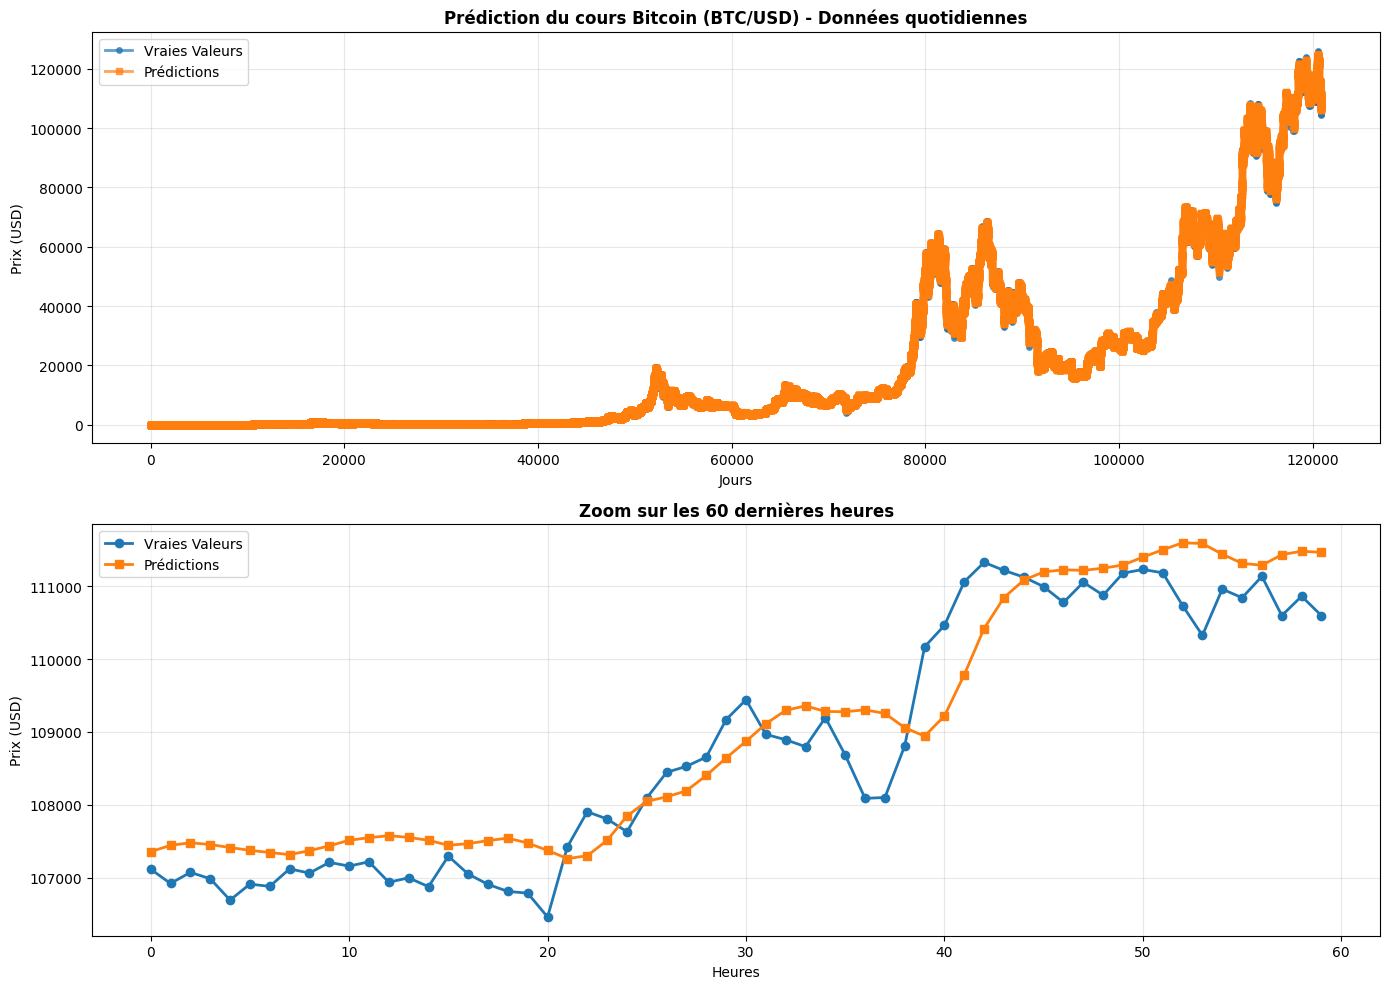


Métriques de performance:
MSE (Mean Squared Error): 113050.6317
MAE (Mean Absolute Error): $172.81
RMSE (Root Mean Squared Error): $336.23
Nombre de prédictions: 120920

Prix moyen prédit: $20601.92
Prix moyen réel: $20616.77


In [9]:
# créer le générateur de test
test_generator = TimeseriesGenerator(data_normalized, data_normalized,
                                     length=look_back, batch_size=1)

# faire les prédictions
predictions_normalized = model.predict(test_generator, verbose=0)

# inverser la normalisation
predictions = scaler.inverse_transform(predictions_normalized)

# récupérer les vraies valeurs
real_values = data[look_back:]

# créer les visualisations
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# graphique 1: Toutes les données quotidiennes
axes[0].plot(real_values, label='Vraies Valeurs', linewidth=2, marker='o', markersize=4, alpha=0.7)
axes[0].plot(predictions, label='Prédictions', linewidth=2, marker='s', markersize=4, alpha=0.7)
axes[0].set_title('Prédiction du cours Bitcoin (BTC/USD) - Données quotidiennes', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Jours')
axes[0].set_ylabel('Prix (USD)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Graphique 2: Zoom sur les 60 dernières heures
start_idx = max(0, len(real_values) - 60)
axes[1].plot(real_values[start_idx:], label='Vraies Valeurs', linewidth=2, marker='o', markersize=6)
axes[1].plot(predictions[start_idx:], label='Prédictions', linewidth=2, marker='s', markersize=6)
axes[1].set_title('Zoom sur les 60 dernières heures', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Heures')
axes[1].set_ylabel('Prix (USD)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

# Sauvegarder le plot dans le dossier images
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
plot_path = f"images/bitcoin_predictions_{timestamp}.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"Plot sauvegardé dans: {plot_path}")

plt.show()


# Calculer les métriques d'erreur
mse = mean_squared_error(real_values, predictions)
mae = mean_absolute_error(real_values, predictions)
rmse = np.sqrt(mse)

print(f"\nMétriques de performance:")
print(f"MSE (Mean Squared Error): {mse:.4f}")
print(f"MAE (Mean Absolute Error): ${mae:.2f}")
print(f"RMSE (Root Mean Squared Error): ${rmse:.2f}")
print(f"Nombre de prédictions: {len(predictions)}")
print(f"\nPrix moyen prédit: ${predictions.mean():.2f}")
print(f"Prix moyen réel: ${real_values.mean():.2f}")
